In [66]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

# Giovanni BENEDETTI DA ROSA

The objective of this practical work is to implement the simple camera calibration method we saw in class. To do that, you will need a several pictures of a calibration pattern, which is chosen here to be a chessboard. 

In the last part, you will furthermore compare you results with the ones of openCV calibration function.

# Part I: load data

First, you have to load several calibration images, which is done in the following cell. The images are provided with this notebook.

**Question:** how many images do you need to calibrate the camera?

**Answer:** In order to calibrate the camera we need at least 3 images. This is a consequence because we need to estimate the 5 dof of the matrix K, the two focal length $f_x$,$f_y$, the two principal point coordinates $p_x$,$p_y$, skew($s$)+ 1 dof of scale $s_c$. So, we need at least three homographies to calibrate the camera.

**Fill** the gaps in the following cell to enter the world coordinates of the corners in the chessboard.

**Explain** why do you have to remove one of the world frame coordinate?

**Answer:** When we are removing the last coordinate, we are considering that $Z = 0$, in other words that all the points belongs to the same plane of a given reference system. This simplification allows to describe the projection of the objects points in the image space as a homography($\mathbb{P}^2 \rightarrow \mathbb{P}^2$), which is a simpler transformation.

In [67]:
import numpy as np

# Create the x and y coordinates
x, y = np.mgrid[0:7, 0:6].T.reshape(-1, 2).T

# Set up the 3D points for the chessboard
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.dstack([x, y])  # Set the x and y coordinates

# Remove a useless dimension in the world coordinates
objpoints = objp[:,:-1]  # Flatten the array

Now, **fill** the code below by entering the path of the folder in which you saved the image.

**Question:** What is the code below doing?

The code is for detecting the corners of a chessboard pattern in the imported images. First, it converts it to grayscale, and it uses a `cv2` function to find the chessboard corners. If corners are detected, refine their positions, add them to a list, and display the image with the marked corners

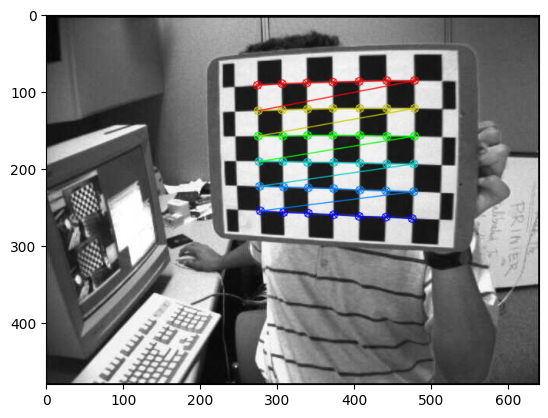

coucou


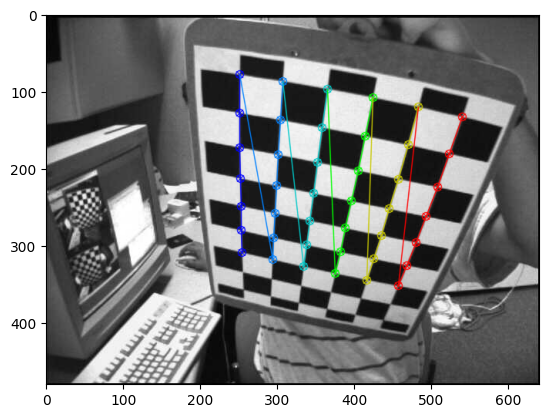

coucou


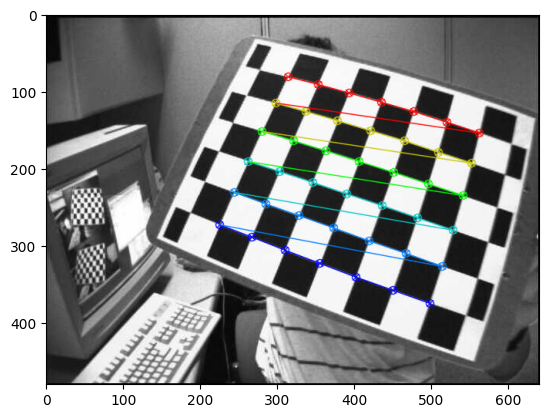

coucou


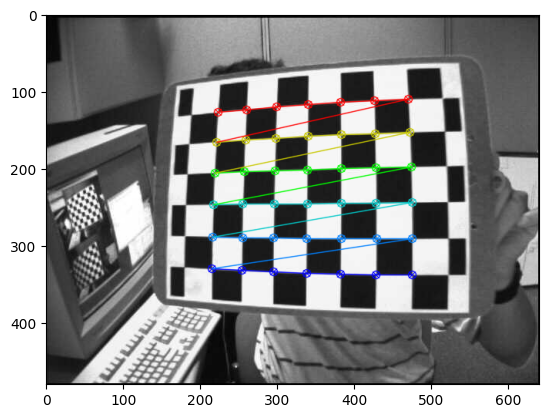

coucou


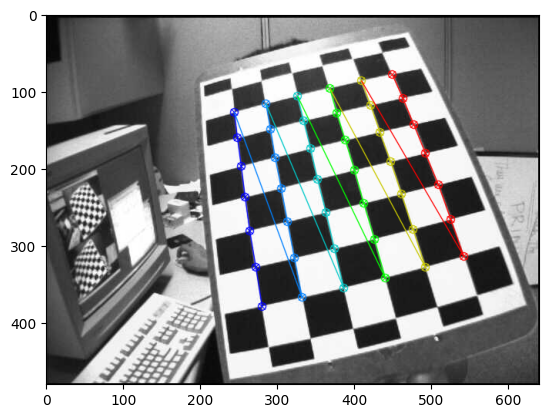

coucou


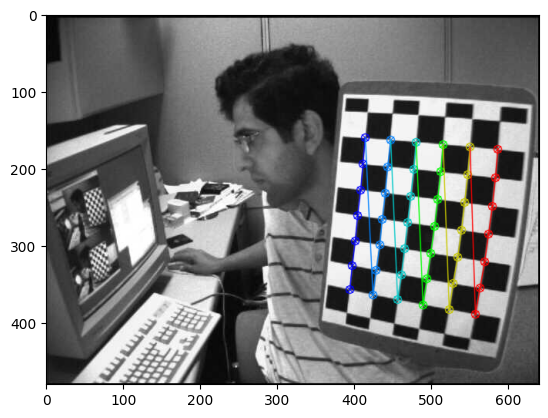

coucou


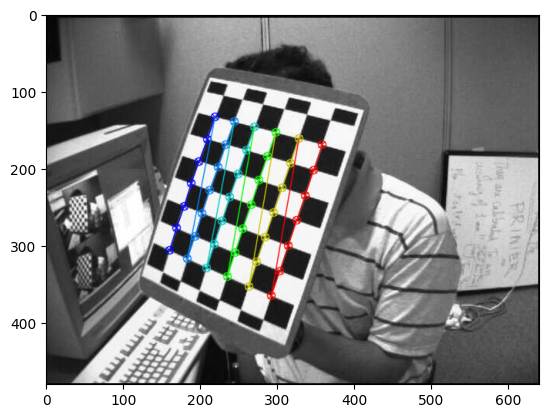

coucou


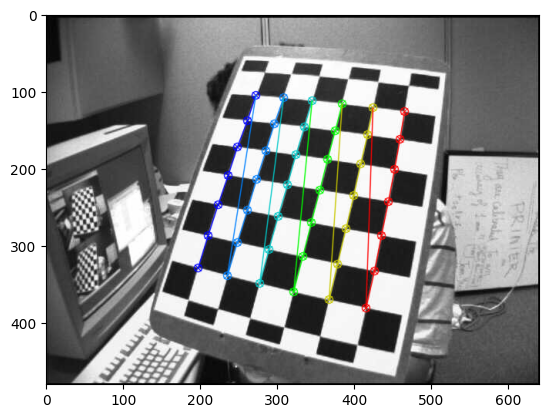

coucou


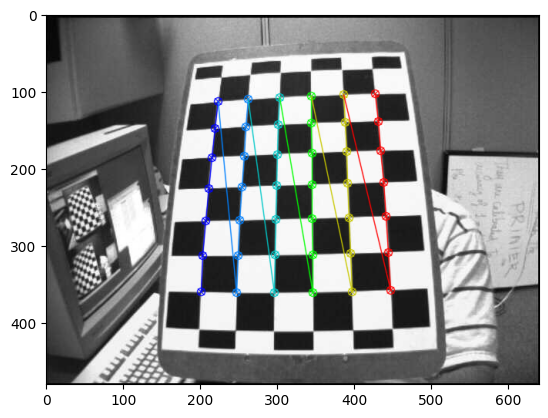

coucou


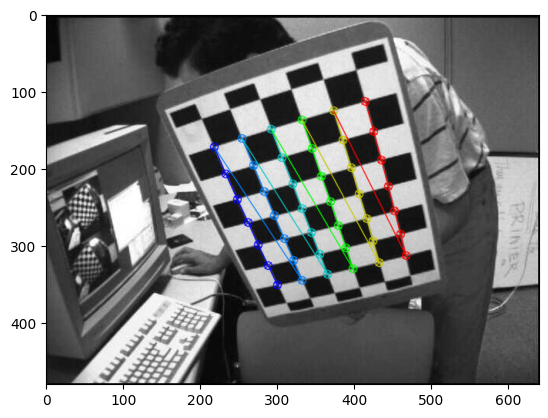

coucou


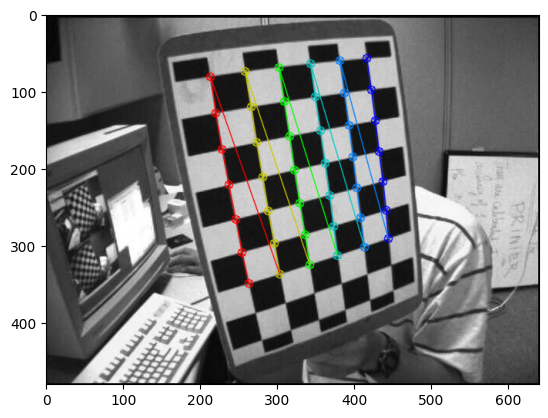

coucou


In [68]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
imgpoints = [] # 2D points in image plane. List (length = nb of images) of np.array, each of size = 2 (corresponding to the 2D Euclidiean coordinates - the coordinates might not be integers)
images = glob.glob('Chessboards/Chessboards/*.jpg') # To be filled + 'Chessboards/*.jpg'
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(np.squeeze(corners2))
        
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        plt.imshow(img)
        plt.show()
        print('coucou')
        
        

# Part II: camera calibration

The objective of this part is to perform the camera calibration using the algorithm we saw in class.

**Question:** Recall what camera calibration is. What parameters are we looking for? 

**Answer:** Camera calibration involves identifying both intrinsic and extrinsic parameters of a camera in order to determine the transformation theat maps a 3D object in the 2D camera space.

* Intrinsic Parameter, specific to the camera and do not change depending on the camera orientation or position:
1. Focal Length($f_x$, $f_y$): This parameter represents the distance from the camera's optical center to its image plane. It essentially defines the camera's zoom level and affects perspective distortion.
1. Principal Point($p_x$, $p_y$): Also known as the image center, it specifies the location of the center point on the image plane. It helps in aligning the image coordinate system with the camera sensor.
1. Skew Coefficient ($s$): Accounts for the non-perpendicularity between the x and y.

* Extrinsic parameters, properties that describe the position and orientation of the camera relative to the world coordinate system:
1. Rotation Matrix: The rotation matrix describes the orientation of the camera's optical axis in three-dimensional space relative to the axes of the world coordinate system, normally represented by 3x3 matrix
1. The translation vector specifies the position of the camera's optical center (also known as the camera center or focal point) relative to the origin of the world coordinate system, normally represented by 3 components vector

**Question:** Recall the main principles of the calibration algorithm we saw in class. What are the main steps that need to be implemented?

**Answer:** 

The Calibration algorithm we saw in class is known as the Zhang algorithm:

1. **Acquisition of Calibration Images**: Capture multiple images of a calibration pattern from different viewpoints using the camera to be calibrated. Normally, a checkerboard.

2. **Detection of Calibration Points**: Detect the corners or keypoints of the calibration pattern in each image. 

3. **Estimation of Intrinsic Parameters**: Use the detected calibration points to estimate the intrinsic parameters of the camera:

$$
\frac{1}{s_c} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix} = K \begin{bmatrix} r_1, r_2, t \end{bmatrix} \begin{bmatrix} X \\ Y  \\ 1 \end{bmatrix}
$$


This can be seen as an unknown Homography($H = (h_1, h_2, h_3)$) which we can determine using the RANSAC algorithm, for example, with two constraints($h_1^TK^{-T}K^{T}h_2 = 0$ and $h_1^TK^{-T}K^{T}h_1 = h_2^TK^{-T}K^{T}h_2$)




Thus, using at least three homographies, we can estimate the intrinsic parameters,  rewritting the equations to solve a linear system, where $h_i$ are the homography components, $B = K^{-T}K^{T}$:

$$h_i^TBh_j = v_{ij}^Tb$$

with $v_{ij} = [h_{i1}H_{j1}, h_{i1}H_{j2}+h_{i2}H_{j1}, h_{i2}H_{j2}, h_{i3}h_{j1}, h_{i1}H_{j3}, h_{i3}H_{j2}+h_{i2}H_{j3}, h_{i3}H_{j3}]$

Then, we can write:

$$\begin{bmatrix} v_{12}^T\\ (v_{11} - v_{22})^T \end{bmatrix} = \begin{bmatrix}0 \\ 0 \end{bmatrix}$$

The goal now is to solve the linear system $Vb = 0$, using SVD, taking the vector with the smallest singular value.

Now with b, we can reshape it. And using cholesky decomposition on the matrix $B = K^{-T}K$, recover the matrix K and thinstrisincs parameters.




4. **Estimation of Extrinsic Parameters**: Compute the rotation and translation matrices (extrinsic parameters), using the previous results:

$$r_1 = \frac{1}{s_c}K^{-1}h_1$$

$$ r_2 = \frac{1}{s_c}K^{-1}h_2$$

$$t = \frac{1}{s_c}K^{-1}h_3$$

$$r_3 = r_1 \times r_2$$


5. **Refinement of Parameters**: Optionally, refine the estimated parameters using nonlinear optimization techniques such as Levenberg-Marquardt optimization to minimize the reprojection error between the observed and projected calibration points.

6. **Assessment of Calibration Accuracy**: Evaluate the accuracy of the calibration by measuring the reprojection error, which quantifies the discrepancy between the observed calibration points in the images and their corresponding projected points computed using the calibrated camera parameters.

To compute the calibration matrix, we first be able to compute some homographies between images. As you have already done so in the previous practical work, some code is provided below.

**Question:** What is the name of the homography estimation algorithm implemented below?

The homography estimation implemented below is DLT.

In [69]:
# Homography computation. See the previous pratical work for more details.
def svd_solve(A):
    """Solve a homogeneous least squares problem with the SVD
       method.

    Args:
       A: Matrix of constraints.
    Returns:
       The solution to the system.
    """
    U, S, V_t = np.linalg.svd(A)
    idx = np.argmin(S)

    least_squares_solution = V_t[idx]

    return least_squares_solution

def to_homogeneous(A):
    """Convert a stack of inhomogeneous vectors to a homogeneous 
       representation.
    """
    A = np.atleast_2d(A)

    N = A.shape[0]
    A_hom = np.hstack((A, np.ones((N,1))))

    return A_hom

def calculate_normalization_matrix(data):
    """Calculates zero-centered, sqrt(2) distance transformed
       matrix transform for data.

       Args:
          data: Nx2 stack of data points
        Returns:
          The normalization matrix
    """
    if data.ndim != 2 or data.shape[-1] != 2:
        raise ValueError('Dataset must be a collection of 2D points')

    x, y = data[:, 0], data[:, 1]

    N = data.shape[0]

    x_mean, y_mean = x.mean(), y.mean()
    x_var, y_var = x.var(), y.var()
    
    # Form rescaling matrix so that data points will lie
    # sqrt(2) from the origin on average.
    s_x, s_y = np.sqrt(2. / x_var), np.sqrt(2. / y_var)
    
    norm_matrix = np.array([[s_x,  0., -s_x * x_mean],
                            [ 0., s_y, -s_y * y_mean],
                            [ 0.,  0.,            1.]])

    return norm_matrix

def calculate_homography(model, data):
    """Perform linear least squares to calculate homography between planar 
       model and sensor data
    """
    N = model.shape[0]

    # Normalize data
    norm_matrix_model = calculate_normalization_matrix(model)
    norm_matrix_data  = calculate_normalization_matrix(data)

    model = to_homogeneous(model)
    data =  to_homogeneous(data)

    model_norm = np.dot(model, norm_matrix_model.T)
    data_norm = np.dot(data, norm_matrix_data.T)

    X, Y, x, y = model_norm[:,0], model_norm[:,1], data_norm[:,0], data_norm[:,1]
    
    # Mount homogeneous constraint matrix (See Burger pg. 11-13 for a derivation)
    A = np.zeros((N * 2, 9))

    x_component = np.zeros((N, 9))
    x_component[:, 0] = -X
    x_component[:, 1] = -Y
    x_component[:, 2] = -1.
    x_component[:, 6] =  x * X
    x_component[:, 7] =  x * Y
    x_component[:, 8] =  x

    y_component = np.zeros((N, 9))
    y_component[:, 3] = -X
    y_component[:, 4] = -Y
    y_component[:, 5] = -1.
    y_component[:, 6] =  y * X
    y_component[:, 7] =  y * Y
    y_component[:, 8] =  y

    # Note that all x-constraints precede all y-constraints for convenience of 
    # representation.
    A[:N] = x_component
    A[N:] = y_component

    # Solve homogeneous system
    h_norm = svd_solve(A)

    # Reconstitute normalized homography
    H_norm = h_norm.reshape((3,3))

    # Denormalize
    H = np.dot(np.dot(np.linalg.inv(norm_matrix_data), H_norm), norm_matrix_model)

    return H

In the following cell, compute the homographies for all the calibrations images in which you have extracted the corner coordinates. 

**Question:** what is the format of the homographies variable? Explain.

**Answer:**

The homographies are  `(3,3)` `arrays`, that represents the transformations from a plane in the model or world coordinate system to the image plane, as captured in each calibration image. Mathemathically, it's the transformation of a point $x = [x, y, 1]^T$ in the model plane to a point $x' = [x', y', 1]^T$, using $x' = Hx$.

In [70]:
# Finds the homography for each image
homographies = []
for iData in range(len(imgpoints)):
    H = calculate_homography(objpoints, imgpoints[iData])
    homographies.append(H)

In [71]:
homographies[7]

array([[ 1.13535333e+01,  1.95660872e+01,  1.10208938e+02],
       [-1.95771772e+01,  1.02259234e+00,  1.86116667e+02],
       [ 1.52203764e-02, -1.29888477e-02,  5.65206500e-01]])

Now, let us start doing the calibration itself. To do that, as seen during the class, you will have to solve a linear system $\mathbf{Vb = 0}$. Recall how the $\mathbf{V}$ matrix is computed from the different homographies found previously.

**Answer:**

As already explained before, we can take the components of the homography $H_i = \lambda K [r_1, r_2, t]$, where $K$ is the camera's intrinsic matrix, $\lambda$ is a scaling factor, $r_1$ and $r_2$ are the first two columns of the rotation matrix $R$, and $t$ is the translation vector.

For each one of the homographies, we can define two contraints equations:

$$h_1^T K^{-T} K^{-1} h_2 = 0$$
$$h_1^T K^{-T} K^{-1} h_1 = h_2^T K^{-T} K^{-1} h_2$$

Then, we can introduce a matrix $B = K^{-T}K and construct the V matrix, where each pair of equations from a homography contributes two rows to V.

$$h_i^TBh_j = v_{ij}^Tb$$

with $v_{ij} = [h_{i1}H_{j1}, h_{i1}H_{j2}+h_{i2}H_{j1}, h_{i2}H_{j2}, h_{i3}h_{j1}, h_{i1}H_{j3}, h_{i3}H_{j2}+h_{i2}H_{j3}, h_{i3}H_{j3}]$

Then, we can write:

$$\begin{bmatrix} v_{12}^T\\ (v_{11} - v_{22})^T \end{bmatrix} = \begin{bmatrix}0 \\ 0 \end{bmatrix}$$

The goal now is to solve the linear system $Vb = 0$, which is used in a least-squares solved through SVD, taking the vector with the smallest singular value.

Now with b, we can reshape it. And using cholesky decomposition on the matrix $B = K^{-T}K$, recover the matrix K and thinstrisincs parameters.


There are two constraints used for performing calibration: the orthogonality constraint and the normalization constraint. Both can be implemented using the $\mathbf{v}_{ij}$ matrix: $\mathbf{v}_{01}$ encodes the orthogonality constraints between $\mathbf{h}_0$ and $\mathbf{h}_1$, while the $\mathbf{v}_{00}$ and $\mathbf{v}_{11}$ encode the normalization constraint for $\mathbf{h}_0$ and $\mathbf{h}_1$. To write the constraints efficiently, code below the generation of $\mathbf{v}_{ij}$ (which will be later on used to implement the $\mathbf{V}$ matrix).

In [72]:
def generate_v_ij(H_stack, i, j):
    """Generate intrinsic ORTHOGONALITY constraints. 
    
    Input:
    - H_stack: a matrix nx3x3 matrix, containing the homographies for the n different images.
    - i: an index of a column of H
    - j: an index of a column of H
    
    Output:
    v_ij: a nx6 matrix containing the orthogonality constraints for all the n images
    """ 
    M = H_stack.shape[0]

    v_ij = np.zeros((M, 6))

    v_ij[:, 0] = H_stack[:, 0, i] * H_stack[:, 0, j]
    v_ij[:, 1] = H_stack[:, 0, i] * H_stack[:, 1, j] + H_stack[:, 1, i] * H_stack[:, 0, j]
    v_ij[:, 2] = H_stack[:, 1, i] * H_stack[:, 1, j]
    v_ij[:, 3] = H_stack[:, 2, i] * H_stack[:, 0, j] + H_stack[:, 0, i] * H_stack[:, 2, j]
    v_ij[:, 4] = H_stack[:, 2, i] * H_stack[:, 1, j] + H_stack[:, 1, i] * H_stack[:, 2, j]
    v_ij[:, 5] = H_stack[:, 2, i] * H_stack[:, 2, j]

    return v_ij



Now, the generate_v_ij function can be used generate the full constraint matrix $\mathbf{V}$ and in turn find the intrinsic parameters.

**Question:** what are the intrinsic and the extrinsic parameters? What is distinguishing them?

**Answer:**

* As already explained above:

**Intrinsic parameters** encompass characteristics inherent to the camera, influencing its internal operations in capturing images and converting three-dimensional points from the environment into two-dimensional points on the image plane, they are defined by the focal lens($f_x, f_y$), Principal Point ($c_x, c_y$) and Skew Coefficient ($s$). They can be represented by the matrix $K$:
$$K = \begin{bmatrix} f_x & s & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}$$

**Extrinsic parameters** detail the camera's spatial positioning and orientation within its environment. They dictate the conversion of coordinates from the world coordinate system to the camera's coordinate system. These parameters are subject to change as the camera traverses its surroundings. They comprise:

- Rotation Matrix ($R$): A 3x3 matrix denoting the camera's orientation relative to the world coordinate system. It specifies the rotational transformation of the camera's axes concerning those of the world.
- Translation Vector ($\vec{t}$): A 3x1 vector indicating the camera's origin location in the world coordinate system. It signifies both the distance and direction of displacement from the world coordinate system's origin.

These extrinsic parameters can be consolidated into a unified 3x4 matrix, denoted as $[R | \vec{t}]$.


The **difference** beetween them is that the instrinsic parameters are fixed for a given camera and they describe the working of the interneal caracteristics of the camera. While the extrinsic parameters are variable the camera's placement and orientation, varying with translation, rotation, etc...

Fill the gaps in the function below to recover the instrinsics.

In [73]:
def recover_intrinsics(homographies):
    """Use computed homographies to calculate intrinsic matrix.
       Requires >= 3 homographies for a full 5-parameter intrinsic matrix.
    """
    M = len(homographies)

    # Stack homographies
    H_stack = np.zeros((M, 3, 3))
    for h, H in enumerate(homographies):
        H_stack[h] = H # H_stack, of size nx3x3 containing all the homographies for the n calibration images

    # Generate constraints
    
    v_00 =  generate_v_ij(H_stack, 0, 0)# Normalization constraint
    v_01 =  generate_v_ij(H_stack, 0, 1)# Orthogonality constraint
    v_11 =  generate_v_ij(H_stack, 1, 1)# Normalization constraint

    
    # Generate the V matrix using v_01,v_00,v_11
    V = np.zeros((2 * M, 6))
    V[:M] = v_01# Orthogonality constraint
    V[M:] = (v_00 - v_11) # Equality of norms constraint
    
    # Use SVD to solve the homogeneous system Vb = 0. You can directly the svd_solve function
    b = svd_solve(V)

    
    # Reshape the coefficients of b to transform them into the B symmetric matrix
    B0, B1, B2, B3, B4, B5 = b
    B = np.array([[B0, B1, B3],
                    [B1, B2, B4],
                    [B3, B4, B5]])
    
    
    # To find K from B, the explicit link between the B and K matrix is used. YOU DON'T NEED TO CHANGE ANYTHING UNTIL THE END OF THE FUNCTION
    # Form auxilliaries
    w = B0 * B2 * B5 - B1**2 * B5 - B0 * B4**2 + 2. * B1 * B3 * B4 - B2 * B3**2
    d = B0 * B2 - B1**2

    # Use Zhang's closed form solution for intrinsic parameters (Zhang, Appendix B, pg. 18)
    v0 = (B[0,1] * B[0,2] - B[0,0] * B[1,2]) / (B[0,0] * B[1,1] - B[0,1] * B[0,1])
    lambda_ = B[2,2] - (B[0,2] * B[0,2] + v0 * (B[0,1] * B[0,2] - B[0,0] * B[1,2])) / B[0,0]
    alpha = np.sqrt(lambda_ / B[0,0])
    beta = np.sqrt(lambda_ * B[0,0] / (B[0,0] * B[1,1] - B[0,1] * B[0,1]))
    gamma = -B[0,1] * alpha * alpha * beta / lambda_
    u0 = gamma * v0 / beta - B[0,2] * alpha * alpha / lambda_

    # Reconstitute intrinsic matrix
    K = np.array([[alpha, gamma, u0],
                  [   0.,  beta, v0],
                  [   0.,    0., 1.]])

    return K

**Question:** The above code use the closed form expression of Zhang for making the link between the $B$ and $K$ matrices. How would you have done otherwise?

**Answer:**

We could have used the Cholseky decomposition method: $B = K^{-T}K^{-1}$. This method decomposes a positive-definite symetric  matrix into the product of a lower triangular matrix and its transpose: $$B = L L^T$$


In this case: $K = (L^{T})^{-1}$

Apply the recover_instrinsics function on the homographies you already computed. What $K$ matrix are you obtaining?

**Answer** We are obtaining the matrix that are formed by the intrinsic parameters.

In [74]:
# Infer the calibration matrix (intrinsics) from the already found homographies
K = recover_intrinsics(homographies)

In [75]:
K

array([[ 5.42429019e+02, -4.57166211e-01,  3.55748672e+02],
       [ 0.00000000e+00,  5.43087152e+02,  2.27293013e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

# Part III - recover the extrinsics

Now, let us compute the extrinsics! Look at the code below and fill the gaps.

**Question:** what is the purpose of the reorthogonalize function and why is it useful?

Reorthogonalize serves to ensure that a rotation matrix remains orthogonal, which means a pure rotation matrix, without any scaling or skewing. But, due to numerical inaccuracies, sometimes this matrix is not anymore perfectly orthogonal. So this process ensure this property.

In [76]:
def to_homogeneous_3d(A):
    """Convert a stack of inhomogeneous vectors (without a Z component)
       to a homogeneous full-form representation.
    """
    if A.ndim != 2 or A.shape[-1] != 2:
        raise ValueError('Stacked vectors must be 2D inhomogeneous')

    N = A.shape[0]
    A_3d = np.hstack((A, np.zeros((N,1))))
    A_3d_hom = to_homogeneous(A_3d)

    return A_3d_hom

def reorthogonalize(R):
    """Determine least distance (Frobenius norm)rotation matrix 
       from a rotation matrix that has drifted away from orthogonality.

    Args:
       R: The matrix to reorthogonalize.
    Returns:
       The reorthogonalized matrix.
    """
    U, S, V_t = np.linalg.svd(R)
    new_R = np.dot(U, V_t)
    return new_R

def recover_extrinsics(H, K):
    """Use computed homography and intrinsic matrix to calculate
       corresponding extrinsic matrix

    Args:
       H: 3x3 homography matrix
       K: 3x3 intrinsic matrix
    Returns:
       3x4 extrinsic matrix
    """
	# Obtain column vectors from homography matrix
    h0, h1, h2 = H[:,0], H[:,1], H[:,2]
    # h0, h1, h2 = ..., ..., ...
    
    # Compute the inverse of the already computed calibration matrix
    K_inv = np.linalg.inv(K)

    # Form normalizer sc
    sc = 1. / np.linalg.norm(np.dot(K_inv, h0))
    lambda_ = 1. / sc
    
    # Compute r0, r1, and t from the homography. r2 can be derived
    # by an orthogonality constraint (np.cross)
    
    r0 = sc * K_inv@h0
    r1 = sc * K_inv@h1
    r2 = np.cross(r0, r1)
    t  = sc * K_inv@h2
    

    # Reconstitute the rotation component of the extrinsics and reorthogonalize
    R = np.vstack((r0, r1, r2)).T
    R = reorthogonalize(R)

    # Reconstitute full extrinsics
    E = np.hstack((R, t[:, np.newaxis]))

    return E

Apply the above function to each homography to recover the extrinsics for each image based on fixed intrinsics. In addition, the projection error is computed for each image so that you can check the result quality. Conclusions?

**Answer**: Except for the images with 41.75 and 38.71 errors, the method for recover the extrinsics seems to work decently. For those points, maybe we have some process in the estimation proccess of the intrinsic parameters due to some movemment or noise in the images that make harder to find a good estimation.

In [77]:
def to_inhomogeneous(A):
    """Convert a stack of homogeneous vectors to an inhomogeneous
       representation.
    """
    A = np.atleast_2d(A)

    N = A.shape[0]
    A /= A[:,-1][:, np.newaxis]
    A_inhom = A[:,:-1]

    return A_inhom


# Recover the extrinsics for each image based on fixed intrinsics
extrinsic_matrices = []
for h, H in enumerate(homographies):
    E = recover_extrinsics(H, K)
    extrinsic_matrices.append(E)
    
    # Look at the projection error
    # Form projection matrix
    P = K@E
    
    model_hom_3d = to_homogeneous_3d(objpoints)
    predicted = np.dot(model_hom_3d, P.T) #x = PX but this writing enables to do the computations for all the points in a single operation
    predicted = to_inhomogeneous(predicted)
    data = imgpoints[h]
    nonlinear_sse_decomp = np.sqrt(np.sum((predicted - data)**2))
    print(nonlinear_sse_decomp)

10.37425863343195
10.748781512261386
15.090693181309996
7.146155252873651
9.21262592183224
41.74984325758979
38.70913053211634
11.768280418682265
13.043482256812943
8.712835732783454
14.878819698743394


In [78]:
print(extrinsic_matrices[2])

[[  0.93337562  -0.35407248   0.058674    -2.80261893]
 [  0.31707147   0.8900931    0.32741404  -2.88017787]
 [ -0.16815362  -0.28699643   0.94305748 -10.51142531]]


# Part IV - distortion

In this last part, we look for the deviations to the linear model by computing the distortions of the camera. For finding the distortion parameters, we will look for a maximum likelihood estimation. Fill the code in the function below.

In [79]:
def calculate_lens_distortion(model, all_data, K, extrinsic_matrices):
    """Calculate least squares estimate of distortion coefficients.

    Args:
       model: Nx2 planar points in the world frame (objpoints)
       all_data: M-length list of Nx2 sensor frame correspondences (imgpoints)
       K: 3x3 intrinsics matrix
       exrinsic_matrices: M-length list of 3x4 extrinsic matrices
    Returns:
       Radial distortion coefficients [k0, k1]
    """
    M = len(all_data)
    N = model.shape[0]

    model = to_homogeneous_3d(model)

    u_c, v_c = K[0,2], K[1,2]

    # Form radius vector
    r = np.zeros(2 * M * N)
    for e, E in enumerate(extrinsic_matrices):
        normalized_projection = np.dot(model, E.T)
        normalized_projection = to_inhomogeneous(normalized_projection)

        x_normalized_proj, y_normalized_proj = normalized_projection[:, 0], normalized_projection[:, 1]
        
        r_i = np.sqrt((x_normalized_proj)**2 + (y_normalized_proj)**2) # Compute the radius
        r[e*N:(e+1)*N] = r_i
    r[M*N:] = r[:M*N]

    # Form observation vector
    obs = np.zeros(2 * M * N)
    u_data, v_data = np.zeros(M * N), np.zeros(M * N)
    for d, data in enumerate(all_data):
        u_i, v_i = data[:, 0], data[:, 1]
        u_data[d*N:(d+1)*N] = u_i
        v_data[d*N:(d+1)*N] = v_i
    obs[:M*N] = u_data
    obs[M*N:] = v_data

    # Form prediction vector
    pred = np.zeros(2 * M * N)
    pred_centered = np.zeros(2 * M * N)
    u_pred, v_pred = np.zeros(M * N), np.zeros(M * N)
    for e, E in enumerate(extrinsic_matrices):
        P = K@E#Compute the projection matrix using K and E
        projection = model@P.T#Project all the 3D points in model using P
        projection = to_inhomogeneous(projection)
        u_pred_i = projection[:, 0]
        v_pred_i = projection[:, 1]

        u_pred[e*N:(e+1)*N] = u_pred_i
        v_pred[e*N:(e+1)*N] = v_pred_i
    pred[:M*N] = u_pred
    pred[M*N:] = v_pred
    pred_centered[:M*N] = u_pred - u_c
    pred_centered[M*N:] = v_pred - v_c

    # Form distortion coefficient constraint matrix
    D = np.zeros((2 * M * N, 2))
    D[:, 0] = pred_centered * r**2
    D[:, 1] = pred_centered * r**4

    # Form values (difference between sensor observations and predictions)
    b = obs - pred

    # Use pseudoinverse technique to compute least squares solution for distortion coefficients
    D_inv = np.linalg.pinv(D)
    k = np.dot(D_inv, b)

    return k

**Question:** in the above function, what is the distortion model used?

**Answer:**The distortion model used is the radial distortion model using a least squares estimation approach.

The model assumes that the distortion can be corrected by adjusting the location of each image point based on its distance from the principal point:

In this case distortion for the x and y components can be written as:
$$x_{\text{distorted}} = x(1 + k_1 r^2 + k_2 r^4)$$
$$y_{\text{distorted}} = y(1 + k_1 r^2 + k_2 r^4)$$

with  $r = \sqrt{x^2 + y^2}$ is the distance of the point from the principal point. So the model returns the ammount of distortion(the components k) applied to the image points based on the radius distance.

Launch the above code to find the distortion parameters and plot the undistorted images. How good do you find the results? Explain how they could be improved.

**Answer:**

It seems that the model didn't applied well for this image, once its borders are still distorted. Also one of the components of k vector is negative and much larger than the other, which can be observed in wide-angle lenses.

In [80]:
k = calculate_lens_distortion(objpoints, imgpoints, K, extrinsic_matrices)

In [81]:
print(k)

[ 0.02723124 -1.07680142]


(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2a29607c190>)

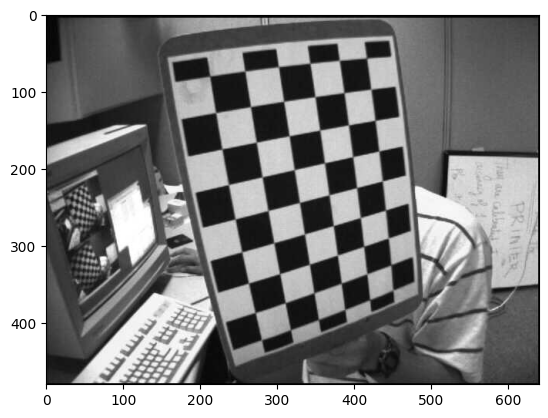

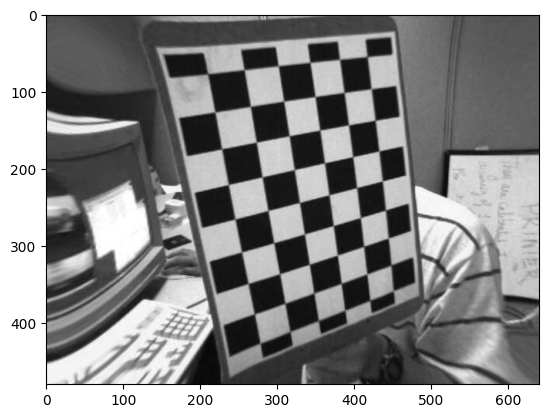

In [82]:
img = cv.imread('Chessboards/Chessboards/left14.jpg')
dst = cv.undistort(img, K,np.array([k[0],k[1],0,0,0]))
plt.imshow(img)
plt.figure(),plt.imshow(dst)

# Part V: comparison with openCV calibration result.

Now, we will use openCV calibration function to compare their results with our. The above cell enables to do so. Compare your calibration matrix, rotation and translation with the result. Conclusions ?

Remark: to obtain the rotation matrices, you can use cv.Rodrigues(rvecs[k])[0]

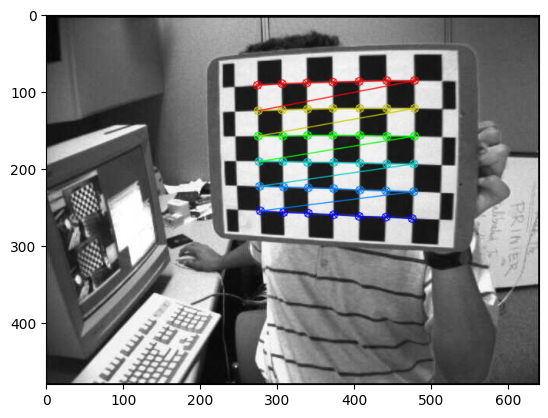

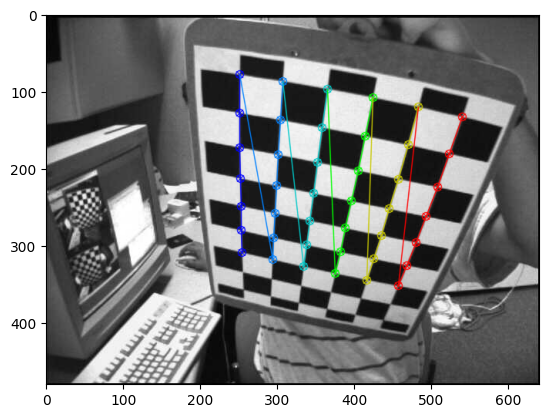

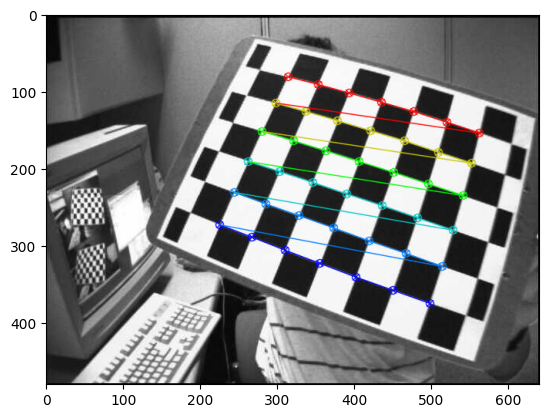

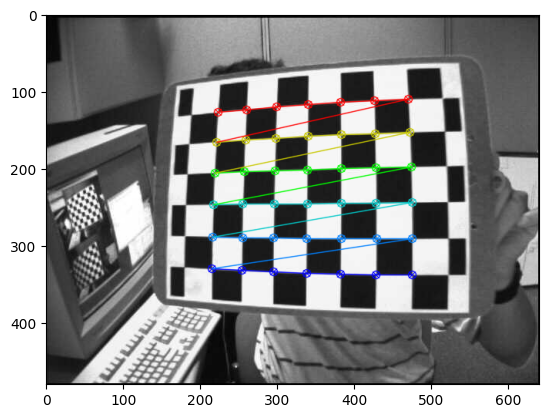

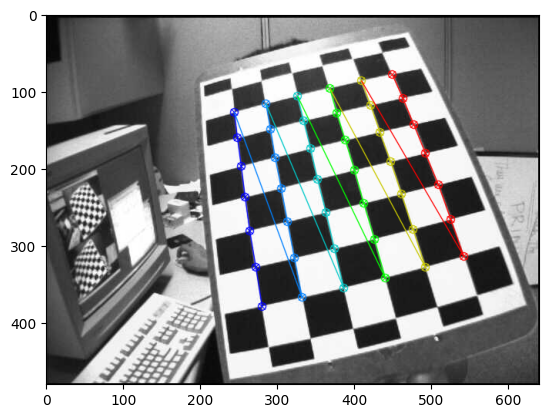

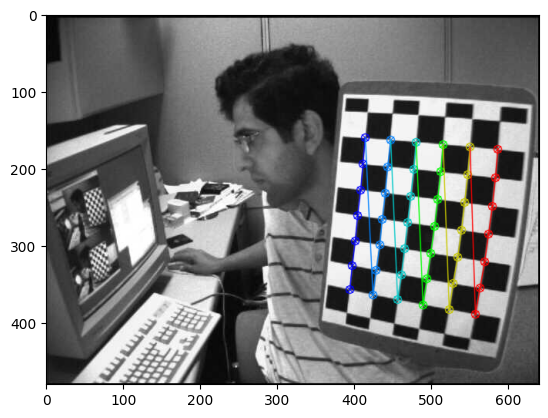

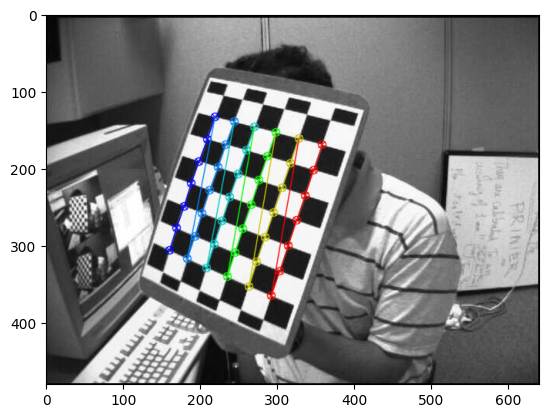

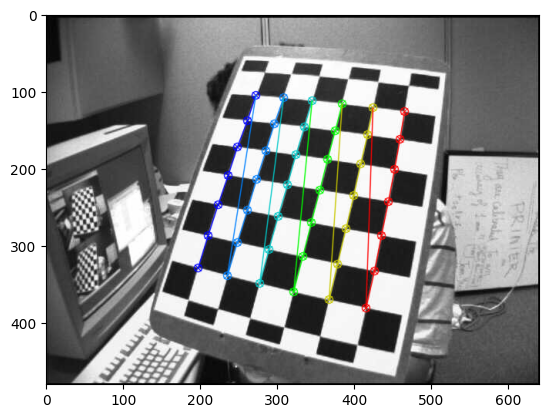

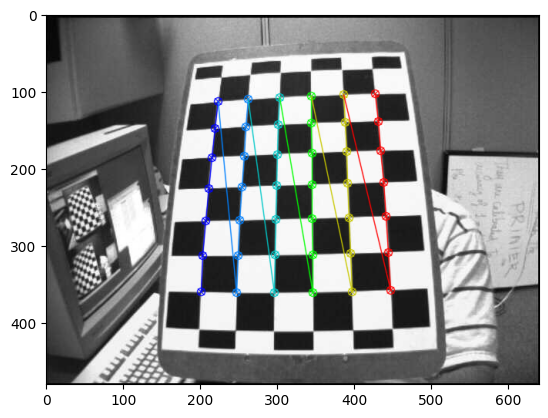

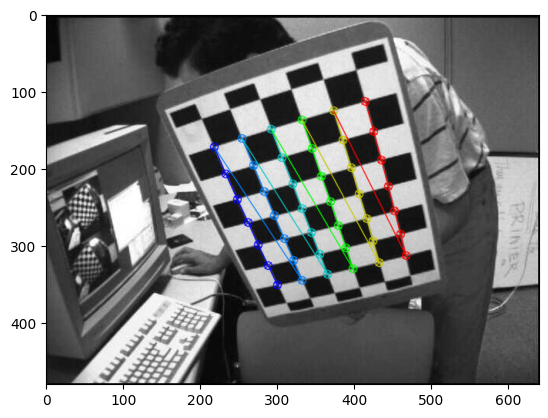

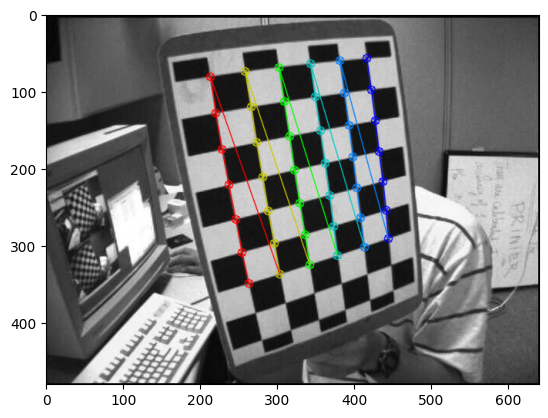

In [83]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space. List (length = nb of images) of np.array, each of size = 3 (corresponding to the 3D Euclidiean coordinates - the last coordinate is always chosen to be 0)
imgpoints = [] # 2d points in image plane. List (length = nb of images) of np.array, each of size = 2 (corresponding to the 2D Euclidiean coordinates - the coordinates might not be integers)
images = glob.glob('Chessboards/Chessboards/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        plt.imshow(img)
        plt.show()

**Answer:**

In [45]:
ret, K, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [46]:
print(cv.Rodrigues(rvecs[2])[0])

[[-0.92086474  0.36672175  0.13237558]
 [-0.31481472 -0.89968619  0.30241768]
 [ 0.22999962  0.23681199  0.94393869]]


In the following cell, the original image and its distorted version using openCV estimation is plotted. Compare with your results. What could explain the differences? You can also use the last cell to compute the projection error.

**Answer:**

The openCV results seems to be better compared to our method, I imagine openCV uses different approaches than the ones that we saw, that somehow considers more than one type of distortion. Maybe, the fecat that OpenCV uses more polynomials in the distortion method used can help in this case.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x2a294d00a30>)

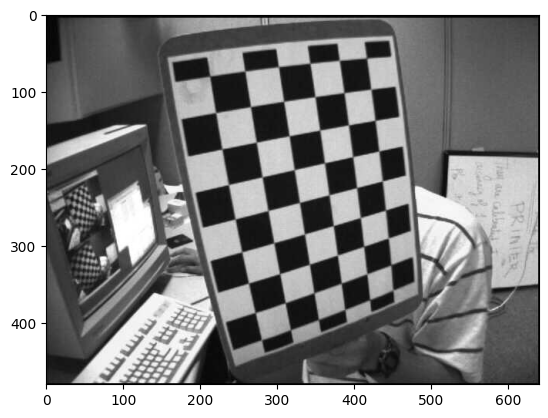

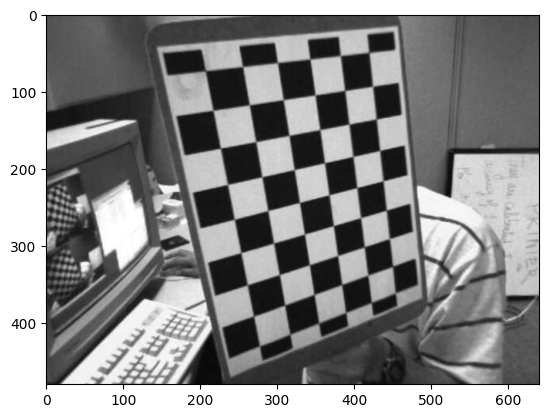

In [47]:
img = cv.imread('Chessboards/Chessboards/left14.jpg')
dst = cv.undistort(img, K, dist, None, K)
plt.imshow(img)
plt.figure(),plt.imshow(dst)

In [59]:
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
    error = cv.norm(imgpoints[i], imgpoints2[:,0], cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\core\src\norm.cpp:1071: error: (-2:Unspecified error) in function 'double __cdecl cv::norm(const class cv::_InputArray &,const class cv::_InputArray &,int,const class cv::_InputArray &)'
> Input type mismatch (expected: '_src1.type() == _src2.type()'), where
>     '_src1.type()' is 13 (CV_32FC2)
> must be equal to
>     '_src2.type()' is 5 (CV_32FC1)
